Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 10.5 MB/s eta 0:00:00
Channels: ['I', 'II', 'RESP', 'SCG']
Sampling rate: 5000
Detected beats: 633


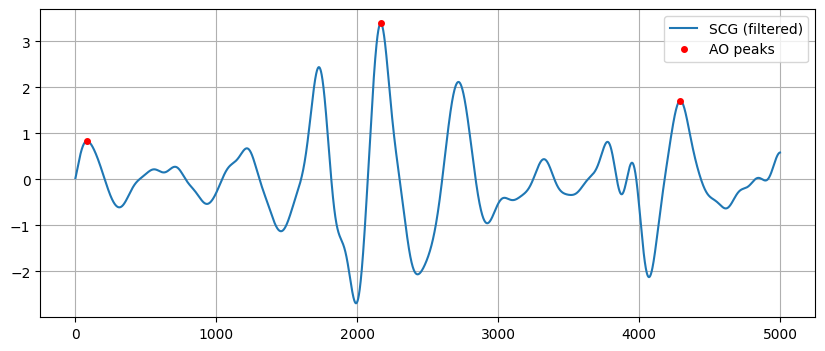

Final dataset shape: (631, 5000)


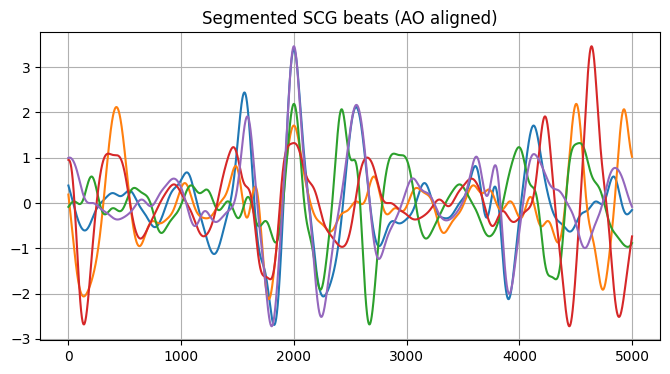

AO candidates detected: 646


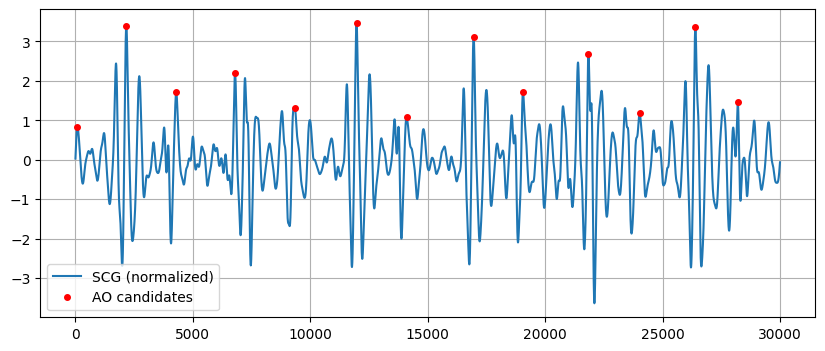

Final SCG segments shape: (644, 5000)


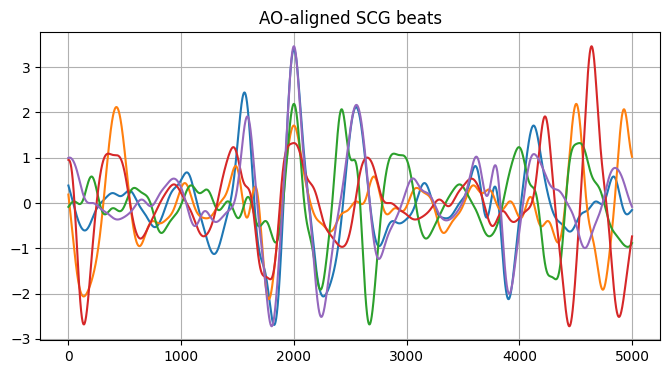

Original beats: 644
Clean beats: 514


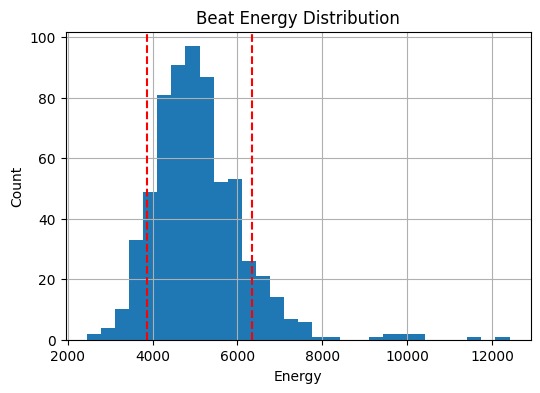

GAN input shape: (514, 5000, 1)


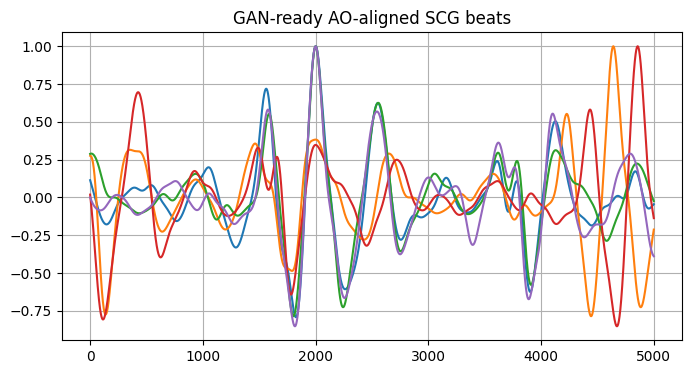

Epoch [0/200] | D Loss: 1.3348 | G Loss: 0.7313
Epoch [20/200] | D Loss: 1.3767 | G Loss: 0.7365
Epoch [40/200] | D Loss: 1.3127 | G Loss: 0.9372
Epoch [60/200] | D Loss: 1.2286 | G Loss: 0.6188
Epoch [80/200] | D Loss: 1.3774 | G Loss: 0.5810
Epoch [100/200] | D Loss: 1.4197 | G Loss: 1.1890
Epoch [120/200] | D Loss: 1.3945 | G Loss: 0.7821
Epoch [140/200] | D Loss: 1.7114 | G Loss: 0.7064
Epoch [160/200] | D Loss: 1.4511 | G Loss: 0.6590
Epoch [180/200] | D Loss: 1.2781 | G Loss: 1.3883
Synthetic NORMAL SCG shape: (2000, 1, 5000)


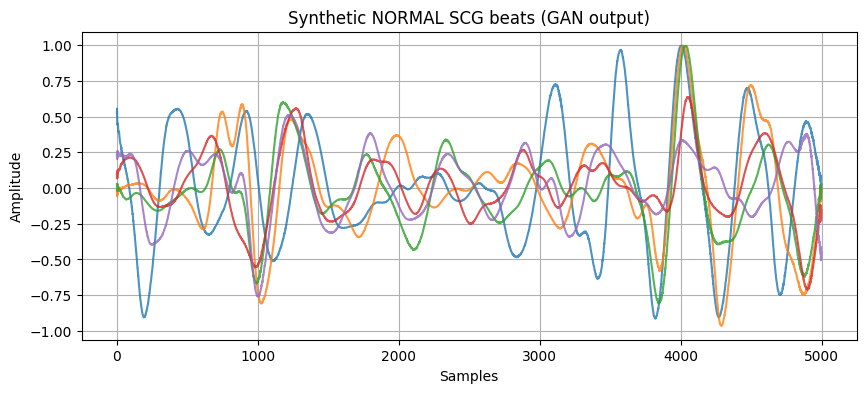

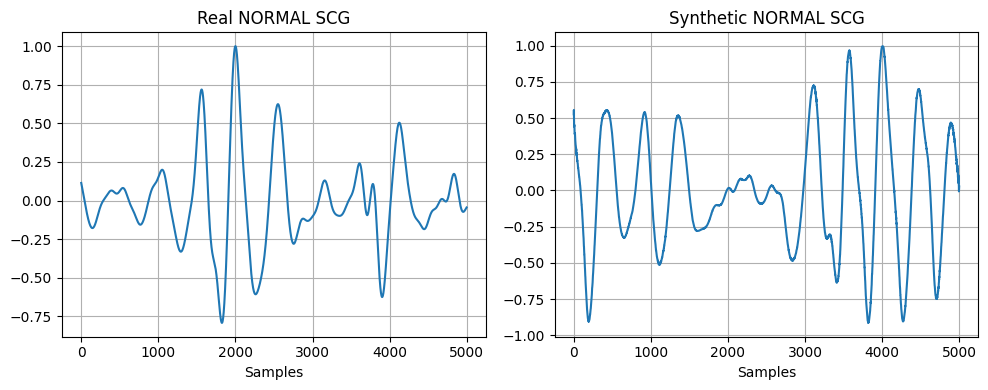

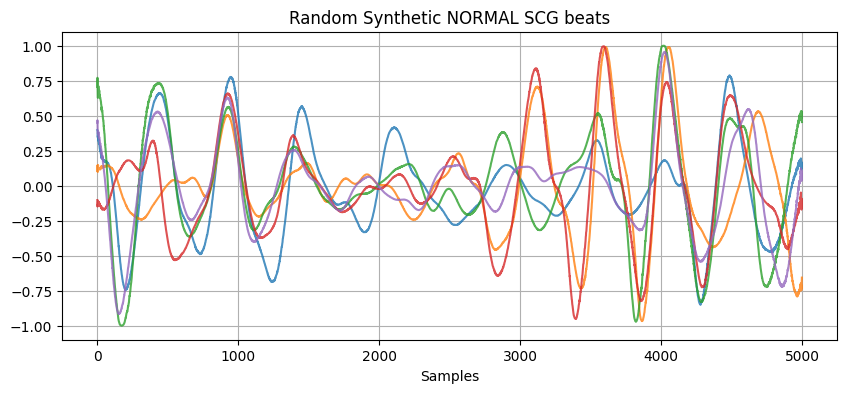

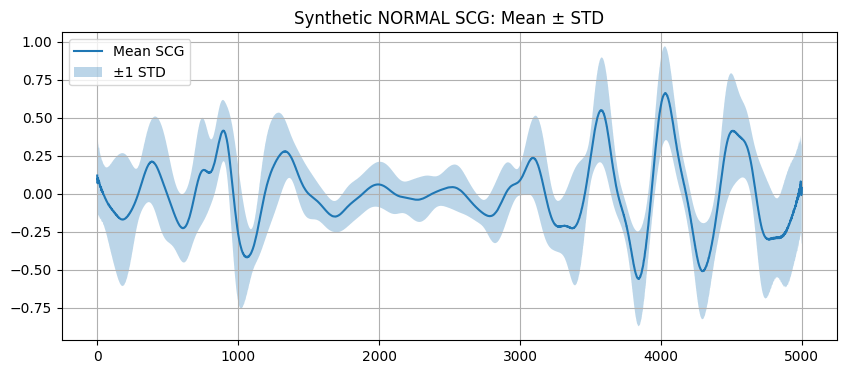

NSTEMI dataset shape: (2056, 5000)


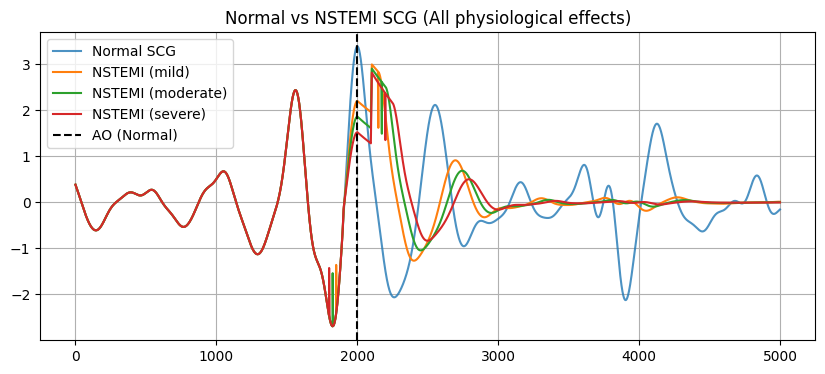

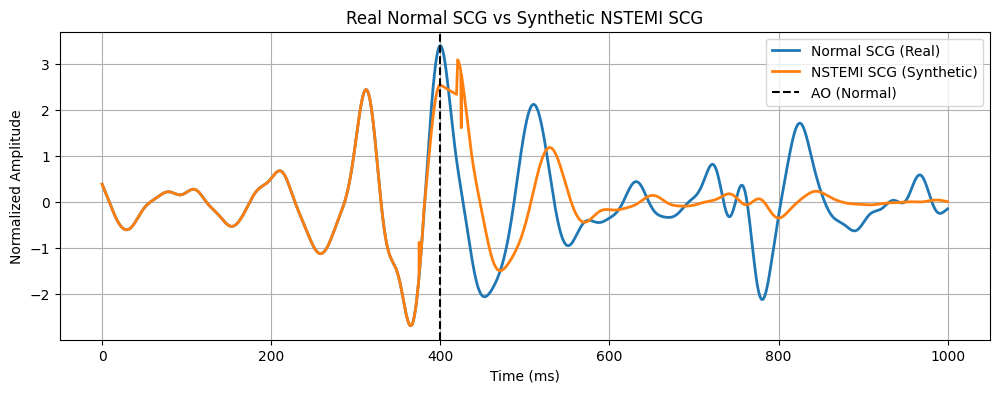

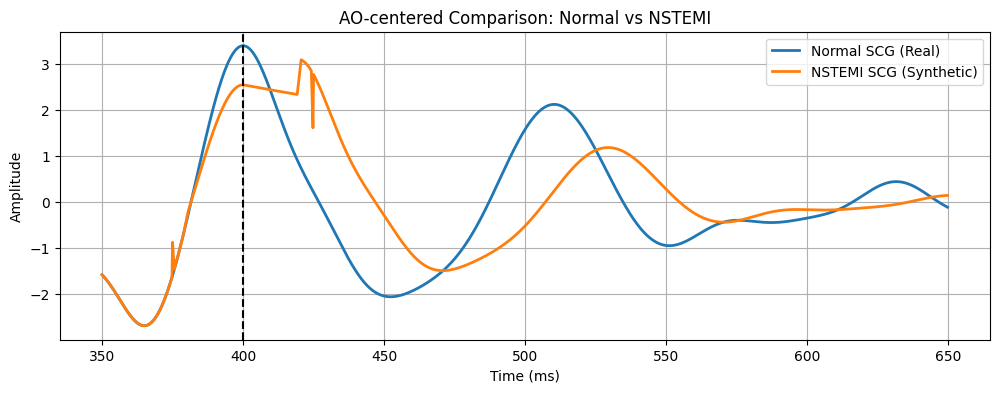

Saved NSTEMI + Normal datasets
STEMI dataset shape: (2056, 5000)
STEMI dataset shape: (2056, 5000)


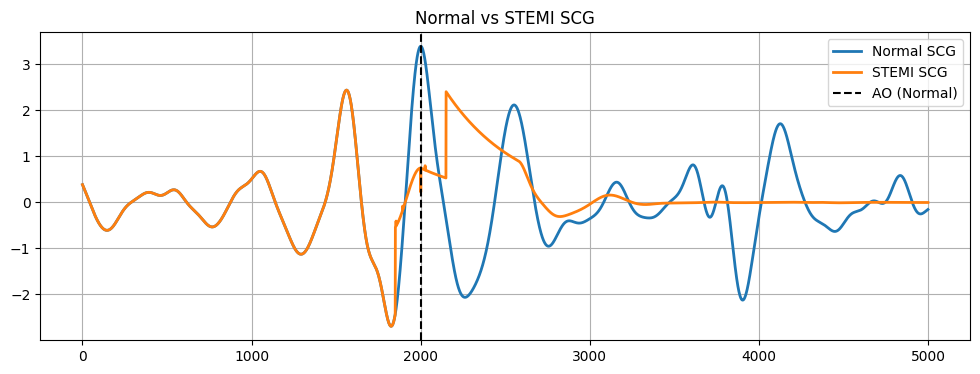

STEMI SCG dataset saved successfully
STEMI shape: (2056, 5000)
✅ All SCG datasets saved to Google Drive


In [ ]:


from google.colab import drive
drive.mount('/content/drive')

# ----------------------------
# 1. Imports
# ----------------------------
!pip install wfdb==4.1.2

!pip install matplotlib
!pip install scipy

import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# ----------------------------
# 2. Load SCG record
# ----------------------------
path = "/content/drive/MyDrive/SCG research papers/Scg Signals/files/p001"
record = wfdb.rdrecord(path)

print("Channels:", record.sig_name)

# Extract SCG channel (from your output: ['I', 'II', 'RESP', 'SCG'])
scg = record.p_signal[:, 3]
fs = record.fs
print("Sampling rate:", fs)

# ----------------------------
# Bandpass filter (5–40 Hz)
# ----------------------------
def bandpass_filter(signal, low=5, high=40, fs=1000, order=4):
    nyq = fs / 2
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, signal)

scg_filt = bandpass_filter(scg, fs=fs)

# ----------------------------
# Z-score normalization
# ----------------------------
scg_norm = (scg_filt - np.mean(scg_filt)) / np.std(scg_filt)

# ----------------------------
# AO peak detection
# ----------------------------
peaks, _ = find_peaks(
    scg_norm,
    height=0.25,
    distance=int(0.4 * fs)
)

print("Detected beats:", len(peaks))

# ----------------------------
# Visualize peaks
# ----------------------------
plt.figure(figsize=(10,4))
plt.plot(scg_norm[:5000], label="SCG (filtered)")
mask = peaks < 5000
plt.plot(peaks[mask], scg_norm[peaks[mask]], "ro", markersize=4, label="AO peaks")
plt.legend()
plt.grid()
plt.show()

# ----------------------------
# Segment beats around AO
# ----------------------------
segments = []

before = int(0.4 * fs)
after  = int(0.6 * fs)

for p in peaks:
    if p-before >= 0 and p+after < len(scg_norm):
        segments.append(scg_norm[p-before : p+after])

segments = np.array(segments)
print("Final dataset shape:", segments.shape)

# ----------------------------
# Plot segmented beats safely
# ----------------------------
if len(segments) > 0:
    plt.figure(figsize=(8,4))
    for i in range(min(5, len(segments))):
        plt.plot(segments[i])
    plt.title("Segmented SCG beats (AO aligned)")
    plt.grid()
    plt.show()
else:
    print("No segments to plot")

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# -----------------------------------
# ASSUMPTION (already done by you)
# scg_norm : band-pass filtered (5–40 Hz) + normalized SCG
# fs       : sampling rate = 5000
# -----------------------------------

# ----------------------------
# 1. Define physiological parameters
# ----------------------------

min_hr = 40      # bpm
max_hr = 180     # bpm

min_distance = int((60 / max_hr) * fs)  # minimum samples between beats
max_distance = int((60 / min_hr) * fs)  # not directly used, for reasoning

# ----------------------------
# 2. Find strong peaks (AO candidates)
# ----------------------------

ao_candidates, properties = find_peaks(
    scg_norm,
    height=0.3,               # amplitude threshold (tunable)
    distance=min_distance     # enforces 1 AO per beat
)

print("AO candidates detected:", len(ao_candidates))

# ----------------------------
# 3. Visualize AO candidates (sanity check)
# ----------------------------

plt.figure(figsize=(10,4))
plt.plot(scg_norm[:30000], label="SCG (normalized)")
mask = ao_candidates < 30000
plt.plot(
    ao_candidates[mask],
    scg_norm[ao_candidates[mask]],
    "ro",
    markersize=4,
    label="AO candidates"
)
plt.legend()
plt.grid()
plt.show()

# ----------------------------
# AO-aligned SCG segmentation
# ----------------------------

pre_AO  = int(0.4 * fs)   # 400 ms before AO
post_AO = int(0.6 * fs)  # 600 ms after AO

scg_segments = []

for ao in ao_candidates:
    start = ao - pre_AO
    end   = ao + post_AO

    # make sure we don't go out of signal bounds
    if start >= 0 and end < len(scg_norm):
        scg_segments.append(scg_norm[start:end])

scg_segments = np.array(scg_segments)

print("Final SCG segments shape:", scg_segments.shape)
plt.figure(figsize=(8,4))
for i in range(min(5, len(scg_segments))):
    plt.plot(scg_segments[i])
plt.title("AO-aligned SCG beats")
plt.grid()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------
# scg_segments shape = (N, 5000)
# ----------------------------------

# ----------------------------
# 1. Compute energy of each beat
# ----------------------------
beat_energy = np.sum(scg_segments**2, axis=1)

# ----------------------------
# 2. Define acceptance range
# ----------------------------
low_thresh  = np.percentile(beat_energy, 10)   # remove weakest 10%
high_thresh = np.percentile(beat_energy, 90)   # remove strongest 10%

# ----------------------------
# 3. Keep only good beats
# ----------------------------
good_mask = (beat_energy >= low_thresh) & (beat_energy <= high_thresh)
scg_clean = scg_segments[good_mask]

print("Original beats:", len(scg_segments))
print("Clean beats:", len(scg_clean))

# ----------------------------
# 4. Visualize energy distribution
# ----------------------------
plt.figure(figsize=(6,4))
plt.hist(beat_energy, bins=30)
plt.axvline(low_thresh, color='r', linestyle='--')
plt.axvline(high_thresh, color='r', linestyle='--')
plt.title("Beat Energy Distribution")
plt.xlabel("Energy")
plt.ylabel("Count")
plt.grid()
plt.show()

# Normalize each beat to [-1, 1]
scg_gan = []

for beat in scg_clean:
    max_val = np.max(np.abs(beat))
    if max_val > 0:
        beat = beat / max_val
    scg_gan.append(beat)

scg_gan = np.array(scg_gan)

# GAN input shape: (N, T, 1)
X_gan = scg_gan[..., np.newaxis]

print("GAN input shape:", X_gan.shape)
plt.figure(figsize=(8,4))
for i in range(min(5, len(X_gan))):
    plt.plot(X_gan[i,:,0])
plt.title("GAN-ready AO-aligned SCG beats")
plt.grid()
plt.show()
np.save("scg_gan_input.npy", X_gan)

#----------------------------------
#---------- GAN Training --------
#----------------------------------

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

class SCGDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = SCGDataset(X_gan)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)




#------------------------
#      GENARATOR CODE
#-------------------------


class SCGGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256 * 125),
            nn.ReLU(),

            nn.Unflatten(1, (256, 125)),

            nn.Upsample(scale_factor=2),
            nn.Conv1d(256, 128, 15, padding=7),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv1d(128, 64, 15, padding=7),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv1d(64, 32, 15, padding=7),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Upsample(scale_factor=5),
            nn.Conv1d(32, 1, 15, padding=7),

            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)


#------------------------
#  Discriminator CODE
#-------------------------

class SCGDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv1d(1, 32, 15, stride=2, padding=7),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            nn.Conv1d(32, 64, 15, stride=2, padding=7),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            nn.Conv1d(64, 128, 15, stride=2, padding=7),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            nn.Conv1d(128, 256, 15, stride=2, padding=7),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x)

latent_dim = 100
device = "cuda" if torch.cuda.is_available() else "cpu"

G = SCGGenerator(latent_dim).to(device)
D = SCGDiscriminator().to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))


epochs = 200

for epoch in range(epochs):
    for real_scg in dataloader:

        real_scg = real_scg.permute(0, 2, 1).to(device)
        batch_size = real_scg.size(0)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ---- Train Discriminator ----
        optimizer_D.zero_grad()

        real_out = D(real_scg)
        d_real_loss = criterion(real_out, real_labels)

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_scg = G(z)
        fake_out = D(fake_scg.detach())
        d_fake_loss = criterion(fake_out, fake_labels)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimizer_D.step()

        # ---- Train Generator ----
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_scg = G(z)
        fake_out = D(fake_scg)

        g_loss = criterion(fake_out, real_labels)
        g_loss.backward()
        optimizer_G.step()

    if epoch % 20 == 0:
        print(f"Epoch [{epoch}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


num_normal_scg = 2000

z = torch.randn(num_normal_scg, latent_dim).to(device)

with torch.no_grad():
    synthetic_normal_scg = G(z).cpu().numpy()

print("Synthetic NORMAL SCG shape:", synthetic_normal_scg.shape)

np.save("normal_scg_synthetic_2000.npy", synthetic_normal_scg)


import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

for i in range(5):  # plot first 5 synthetic beats
    plt.plot(synthetic_normal_scg[i, 0], alpha=0.8)

plt.title("Synthetic NORMAL SCG beats (GAN output)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()
plt.show()
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(X_gan[0,:,0])
plt.title("Real NORMAL SCG")
plt.xlabel("Samples")
plt.grid()

plt.subplot(1,2,2)
plt.plot(synthetic_normal_scg[0,0])
plt.title("Synthetic NORMAL SCG")
plt.xlabel("Samples")
plt.grid()

plt.tight_layout()
plt.show()

import numpy as np

idx = np.random.choice(len(synthetic_normal_scg), 5, replace=False)

plt.figure(figsize=(10,4))
for i in idx:
    plt.plot(synthetic_normal_scg[i,0], alpha=0.8)

plt.title("Random Synthetic NORMAL SCG beats")
plt.xlabel("Samples")
plt.grid()
plt.show()

mean_scg = np.mean(synthetic_normal_scg[:,0,:], axis=0)
std_scg  = np.std(synthetic_normal_scg[:,0,:], axis=0)

plt.figure(figsize=(10,4))
plt.plot(mean_scg, label="Mean SCG")
plt.fill_between(
    np.arange(len(mean_scg)),
    mean_scg - std_scg,
    mean_scg + std_scg,
    alpha=0.3,
    label="±1 STD"
)
plt.title("Synthetic NORMAL SCG: Mean ± STD")
plt.legend()
plt.grid()
plt.show()

AO_INDEX = int(0.4 * fs)

def ao_delay_function(beat, ao_index, delay_ms, fs):
    delay_samples = int((delay_ms / 1000) * fs)
    out = beat.copy()

    if ao_index + delay_samples >= len(beat):
        return out

    # Shift post-AO region to the right
    out[ao_index + delay_samples:] = beat[ao_index:-delay_samples]

    # Hold AO value (mechanical delay)
    out[ao_index:ao_index + delay_samples] = beat[ao_index]

    return out


#--------------------------------------------------------------
#-----------------  AO Amplitutde Reduction -------------------
#--------------------------------------------------------------

def ao_amplitude_reduction(beat, ao_index, fs, window_ms=40, scale=0.7):
    half = int((window_ms / 1000) * fs / 2)
    start = max(ao_index - half, 0)
    end   = min(ao_index + half, len(beat))

    out = beat.copy()
    out[start:end] *= scale
    return out

#--------------------------------------------------------------
#-----------------  AO ROunding  -------------------
#--------------------------------------------------------------

def round_ao_peak(beat, ao_index, fs, window_ms=60):
    half = int((window_ms / 1000) * fs / 2)
    start = max(ao_index - half, 0)
    end   = min(ao_index + half, len(beat))

    segment = beat[start:end]
    kernel = np.ones(7) / 7
    smooth = np.convolve(segment, kernel, mode="same")

    out = beat.copy()
    out[start:end] = smooth
    return out


def damp_post_ao(beat, ao_index, decay_rate=6.0, fs=1000):
    out = beat.copy()
    t = np.arange(len(beat) - ao_index) / fs
    envelope = np.exp(-decay_rate * t)

    out[ao_index:] *= envelope
    return out

def generate_nstemi_beat(
    normal_beat,
    fs,
    ao_index,
    ao_delay_ms=30,
    ao_amp_scale=0.65,
    ao_round_ms=60,
    damping_rate=6.0
):
    beat = normal_beat.copy()

    beat = ao_delay_function(beat, ao_index, ao_delay_ms, fs)
    beat = ao_amplitude_reduction(beat, ao_index, fs, scale=ao_amp_scale)
    beat = round_ao_peak(beat, ao_index, fs, window_ms=ao_round_ms)
    beat = damp_post_ao(beat, ao_index, damping_rate, fs)

    return beat

nstemi_all = []

severity_params = [
    dict(ao_delay_ms=20, ao_amp_scale=0.75, ao_round_ms=50, damping_rate=4.5),
    dict(ao_delay_ms=30, ao_amp_scale=0.65, ao_round_ms=60, damping_rate=6.0),
    dict(ao_delay_ms=40, ao_amp_scale=0.55, ao_round_ms=70, damping_rate=7.5),
    dict(ao_delay_ms=50, ao_amp_scale=0.45, ao_round_ms=80, damping_rate=9.0),
]

for beat in scg_clean:
    for params in severity_params:
        nstemi_beat = generate_nstemi_beat(
            beat,
            fs,
            AO_INDEX,
            **params
        )
        nstemi_all.append(nstemi_beat)

nstemi_all = np.array(nstemi_all)

print("NSTEMI dataset shape:", nstemi_all.shape)
plt.figure(figsize=(10,4))

plt.plot(scg_clean[0], label="Normal SCG", alpha=0.8)
plt.plot(nstemi_all[1], label="NSTEMI (mild)")
plt.plot(nstemi_all[2], label="NSTEMI (moderate)")
plt.plot(nstemi_all[3], label="NSTEMI (severe)")

plt.axvline(AO_INDEX, color="k", linestyle="--", label="AO (Normal)")
plt.legend()
plt.grid()
plt.title("Normal vs NSTEMI SCG (All physiological effects)")
plt.show()

normal_beat = scg_clean[0]     # real normal
nstemi_beat = nstemi_all[0]    # synthetic NSTEMI

t = np.arange(len(normal_beat)) / fs * 1000

plt.figure(figsize=(12,4))

plt.plot(t, normal_beat, label="Normal SCG (Real)", linewidth=2)
plt.plot(t, nstemi_beat, label="NSTEMI SCG (Synthetic)", linewidth=2)

plt.axvline(AO_INDEX / fs * 1000, color="k", linestyle="--", label="AO (Normal)")

plt.xlabel("Time (ms)")
plt.ylabel("Normalized Amplitude")
plt.title("Real Normal SCG vs Synthetic NSTEMI SCG")
plt.legend()
plt.grid()
plt.show()

zoom_start = AO_INDEX - int(0.05 * fs)
zoom_end   = AO_INDEX + int(0.25 * fs)

plt.figure(figsize=(12,4))

plt.plot(
    t[zoom_start:zoom_end],
    normal_beat[zoom_start:zoom_end],
    label="Normal SCG (Real)",
    linewidth=2
)

plt.plot(
    t[zoom_start:zoom_end],
    nstemi_beat[zoom_start:zoom_end],
    label="NSTEMI SCG (Synthetic)",
    linewidth=2
)

plt.axvline(AO_INDEX / fs * 1000, color="k", linestyle="--")

plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("AO-centered Comparison: Normal vs NSTEMI")
plt.legend()
plt.grid()
plt.show()

np.save("nstemi_scg_dataset.npy", nstemi_all)
np.save("normal_scg_dataset.npy", scg_clean)

print("Saved NSTEMI + Normal datasets")

############ STEMI SCG ##################

#--------------- AO DELAY ---------------

def ao_delay_function(beat, ao_index, delay_ms, fs):
    delay_samples = int((delay_ms / 1000) * fs)
    out = beat.copy()

    if ao_index + delay_samples >= len(beat):
        return out

    out[ao_index + delay_samples:] = beat[ao_index:-delay_samples]
    out[ao_index:ao_index + delay_samples] = beat[ao_index]

    return out

#-------------SEVERE AO AMPLITUDE COLLAPSE-------

def collapse_ao_amplitude(beat, ao_index, scale=0.3, window_ms=60, fs=1000):
    half = int((window_ms / 1000) * fs / 2)
    start = max(ao_index - half, 0)
    end   = min(ao_index + half, len(beat))

    out = beat.copy()
    out[start:end] *= scale
    return out

#--------- AO FRAGMENTATION ---------------------

def fragment_ao_peak(beat, ao_index, fs, num_fragments=3, spread_ms=30):
    out = beat.copy()
    spread = int(spread_ms * fs / 1000)

    # suppress original AO
    out[ao_index] *= 0.3

    for i in range(num_fragments):
        shift = np.random.randint(-spread, spread)
        idx = ao_index + shift

        if 0 <= idx < len(out):
            out[idx] += 0.15 * beat[ao_index] * np.random.uniform(0.6, 1.0)

    return out

#--------EXTREME POST-AO DAMPING------------------

def strong_post_ao_damping(beat, ao_index, fs, decay_rate=12.0):
    out = beat.copy()
    t = np.arange(len(beat) - ao_index) / fs
    envelope = np.exp(-decay_rate * t)

    out[ao_index:] *= envelope
    return out


def generate_stemi_beat(
    normal_beat,
    fs,
    ao_index,
    ao_delay_ms=90,
    ao_amp_scale=0.3,
    fragment=True,
    damping_rate=12.0
):
    beat = normal_beat.copy()

    # 1. Severe PEP prolongation
    beat = ao_delay_function(beat, ao_index, ao_delay_ms, fs)

    # 2. AO amplitude collapse
    beat = collapse_ao_amplitude(
        beat,
        ao_index,
        scale=ao_amp_scale,
        fs=fs
    )

    # 3. AO fragmentation
    if fragment:
        beat = fragment_ao_peak(beat, ao_index, fs)

    # 4. Near-total systolic damping
    beat = strong_post_ao_damping(
        beat,
        ao_index,
        fs,
        decay_rate=damping_rate
    )

    return beat

stemi_all = []

NUM_STEMI_VARIANTS = 4   # 500 × 4 = 2000 STEMI beats

for beat in scg_clean:
    for _ in range(NUM_STEMI_VARIANTS):
        stemi_beat = generate_stemi_beat(
            beat,
            fs,
            AO_INDEX,
            ao_delay_ms=np.random.uniform(70, 120),
            ao_amp_scale=np.random.uniform(0.2, 0.4),
            fragment=True,
            damping_rate=np.random.uniform(10, 14)
        )
        stemi_all.append(stemi_beat)

stemi_all = np.array(stemi_all)

print("STEMI dataset shape:", stemi_all.shape)


print("STEMI dataset shape:", stemi_all.shape)

plt.figure(figsize=(12,4))

plt.plot(scg_clean[0], label="Normal SCG", linewidth=2)
plt.plot(stemi_all[0], label="STEMI SCG", linewidth=2)

plt.axvline(AO_INDEX, linestyle="--", color="k", label="AO (Normal)")
plt.legend()
plt.grid()
plt.title("Normal vs STEMI SCG")
plt.show()

np.save("stemi_scg_dataset.npy", stemi_all)

print("STEMI SCG dataset saved successfully")
print("STEMI shape:", stemi_all.shape)

SAVE_DIR = "/content/drive/MyDrive/SCG research papers/SCG_Datasets"

import os
os.makedirs(SAVE_DIR, exist_ok=True)
import numpy as np

# Save Normal SCG
np.save(f"{SAVE_DIR}/normal_scg_real.npy", scg_clean)

# Save GAN-generated Normal SCG
np.save(f"{SAVE_DIR}/normal_scg_gan.npy", synthetic_normal_scg)

# Save NSTEMI SCG
np.save(f"{SAVE_DIR}/nstemi_scg.npy", nstemi_all)

# Save STEMI SCG
np.save(f"{SAVE_DIR}/stemi_scg.npy", stemi_all)

# Save metadata (VERY good practice)
np.save(f"{SAVE_DIR}/fs.npy", fs)
np.save(f"{SAVE_DIR}/ao_index.npy", AO_INDEX)

print("✅ All SCG datasets saved to Google Drive")

